In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

## SGD

In [11]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_roberta_multi'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.4810606060606061, 'as': 0.48370273794002605, 'about': 0.5102040816326531}
Accuracy evaluando en etiquetas female
{'to': 1.0, 'as': 1.0, 'about': 1.0}
Accuracy evaluando en etiquetas male
{'to': 0.0, 'as': 0.0, 'about': 0.0}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0791448230112057 	 Validation loss: 2.0800653473805575 	 
  1%|          | 574/57400 [01:16<2:10:02,  7.28it/s]
Epoch 2 	 Training loss: 2.0768084837584544 	 Validation loss: 2.0792733653117033 	 
  2%|▏         | 1148/57400 [02:34<2:06:13,  7.43it/s]
Epoch 3 	 Training loss: 2.0759534229384897 	 Validation loss: 2.0803551471839516 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [03:52<1:48:10,  8.58it/s]
Epoch 4 	 Training loss: 2.0750604693482564 	 Validation loss: 2.0790162692635747 	 
  4%|▍         | 2296/57400 [05:11<2:03:53,  7.41it/s]
Epoch 5 	 Training loss: 2.0735127738959283 	 Validation loss: 2.0765284400875283 	 
  5%|▌         | 2870/57400 [06:30<1:47:01,  8.49it/s]
Epoch 6 	 Training loss: 2.060605906858677 	 Validation loss: 2.0312163546933966 	 
  6%|▌         | 3444/57400 [07:50<1:51:39,  8.05it/s]
Epoch 7 	 Training loss: 2.0125351028990663 	 Validation loss: 2.0069835327439387 	 
  7%|▋         | 4018/57400 [09:10<1:51:24,  7.9

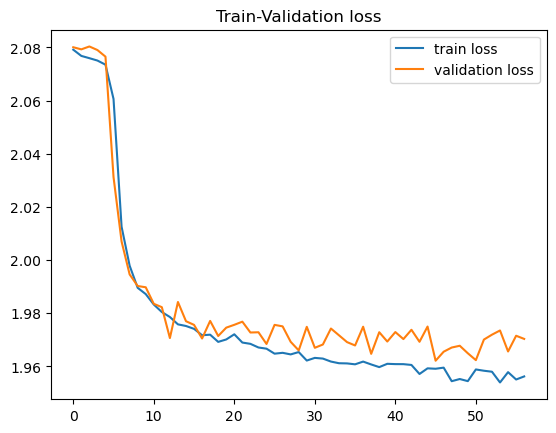

In [13]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [14]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.7272727272727273, 'as': 0.7209908735332464, 'about': 0.8482142857142857}
Accuracy evaluando en etiquetas female
{'to': 0.7165354330708661, 'as': 0.7358490566037735, 'about': 0.86}
Accuracy evaluando en etiquetas male
{'to': 0.7372262773722628, 'as': 0.7070707070707071, 'about': 0.8359375}


## AdamW

In [15]:
model = mt.MultiTaskSimple(model_conf).to(device)
save_path='m1_roberta_multi_adamW'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0858932841530247 	 Validation loss: 2.084462868965278 	 
  1%|          | 574/57400 [01:31<2:22:24,  6.65it/s]
Epoch 2 	 Training loss: 2.0770823764468735 	 Validation loss: 2.0853666329787948 	 
  2%|▏         | 1148/57400 [03:03<2:26:54,  6.38it/s]
Epoch 3 	 Training loss: 2.0766109448276744 	 Validation loss: 2.080807047375178 	 
  3%|▎         | 1722/57400 [04:35<2:26:55,  6.32it/s]
Epoch 4 	 Training loss: 2.076511986164266 	 Validation loss: 2.079953367427244 	 
  4%|▍         | 2296/57400 [06:07<2:30:49,  6.09it/s]
Epoch 5 	 Training loss: 2.0767261944581406 	 Validation loss: 2.0805493168911693 	 
  5%|▌         | 2870/57400 [07:38<2:15:28,  6.71it/s]
Epoch 6 	 Training loss: 2.076209282625843 	 Validation loss: 2.0802589998406877 	 
  6%|▌         | 3444/57400 [09:11<2:15:04,  6.66it/s]
Epoch 7 	 Training loss: 2.075874313244836 	 Validation loss: 2.0823514986846408 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [10:42<2:16:33,  6.52it/s

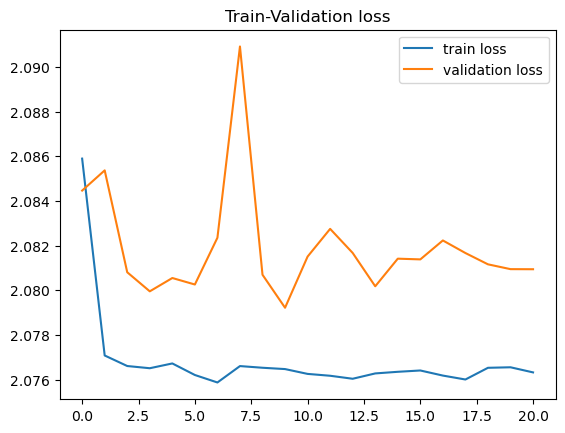

In [16]:
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [17]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.5189393939393939, 'as': 0.516297262059974, 'about': 0.4897959183673469}
Accuracy evaluando en etiquetas female
{'to': 0.0, 'as': 0.0, 'about': 0.0}
Accuracy evaluando en etiquetas male
{'to': 1.0, 'as': 1.0, 'about': 1.0}
